# BESS Optimization -  Diego Cerda - DS

In [1]:
# Install Dependencies
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from neuralprophet import NeuralProphet, set_log_level
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
from pulp import *
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")


/Users/home/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
# Data load & Clean Up
df = pd.read_csv('Day-ahead_Prices_60min.csv')
df[['start_datetime', 'end_datetime']] = df['MTU (CET/CEST)'].str.split(' - ', expand=True)
df['start_datetime'] = pd.to_datetime(df['start_datetime'], format='%d.%m.%Y %H:%M')
df['end_datetime'] = pd.to_datetime(df['end_datetime'], format='%d.%m.%Y %H:%M')
df.drop(columns=['MTU (CET/CEST)','Currency','BZN|DE-LU'], inplace=True)
df.rename(columns={'Day-ahead Price [EUR/MWh]':'price'}, inplace=True)
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df.ffill(inplace=True)

# Question 1.1
For every day in the data, find the profit-maximizing times to charge and discharge the battery. Illustrate
your findings, showing for example how much revenue you would have earned, at what times of the day it is
usually best to charge and when it is best to discharge, etc. Please list any assumptions you make, if any.

### Assumptions

* Battery Energy Storage System (BESS) with 1 MW / 1 MWh.
* 1 cycle/day and 100% efficiency.
* We start our arbitrage with an empty battery and a SoC of 0.
* Perfect price foresight for the optimization period.
* No degradation costs.
* No minimum state of charge requirements.
* Instant ramp rates (can go from full charge to full discharge between hours).


### Additional Considerations
* Consider including round-trip efficiency losses.
* Account for any minimum state of charge requirements.
* Include any battery degradation costs.
* Consider ramp rate limitations if applicable.
* No market constraints.



#### Basic Example
- Period 1: Price = \$30/MWh
- Period 2: Price = \$100/MWh
- Efficiency = 0.95

If charging 1 MW in period 1:

- charging_cost = 1 MW × $30/MWh = $30
- energy_stored = 1 MWh × 0.95 = 0.95 MWh

When discharging in period 2:
- energy_discharged = 0.95 MWh ÷ 0.95 = 1 MWh
- revenue = 1 MW × \$100/MWh = \$100

Net profit = \$100 - \$30 = \$70



In [3]:
# Creating a class to be used to anwser question 1.2
class BatteryOptimizer:
    def __init__(self, power_capacity=1.0, energy_capacity=1.0, efficiency=0.95) => (str) :
        self.power_capacity = power_capacity
        self.energy_capacity = energy_capacity # this can be 1MW or 2MW
        self.efficiency = efficiency

    @de
    def optimize(self, df:pd.DataFrame, x:int):
        prices = df['price'].values
        T = len(prices)
        
        # Create optimization problem
        model = LpProblem("Battery_Optimization", LpMaximize)
        
        # Decision variables
        charge = [LpVariable(f"charge_{t}", 0, self.power_capacity) for t in range(T)]
        discharge = [LpVariable(f"discharge_{t}", 0, self.power_capacity) for t in range(T)]
        energy = [LpVariable(f"energy_{t}", 0, self.energy_capacity) for t in range(T)]
        
        # Objective function
        model += lpSum([prices[t] * (discharge[t] - charge[t]) for t in range(T)])
        
        # Constraints
        # Initial condition
        model += energy[0] == self.efficiency * charge[0] - discharge[0] * (1/self.efficiency)
        
        # Energy balance for subsequent periods
        for t in range(1, T):
            model += energy[t] == (energy[t-1] + 
                                 self.efficiency * charge[t] - 
                                 discharge[t] * (1/self.efficiency))
            
            # No simultaneous charge/discharge
            model += charge[t] + discharge[t] <= self.power_capacity
        
        # Solve
        model.solve(PULP_CBC_CMD(msg=0))
        
        # Extract results
        results = {
            'charge': [charge[t].varValue for t in range(T)],
            'discharge': [discharge[t].varValue for t in range(T)],
            'energy': [energy[t].varValue for t in range(T)],
            'profit': value(model.objective)
        }
        
        return results
    
    def analyze_results(self, df, results):
        # Create results dataframe
        df_results = df.copy()
        
        # Add hour and date from start_timestamp
        df_results['hour'] = df_results['start_datetime'].dt.hour
        df_results['date'] = df_results['start_datetime'].dt.date
        
        # Add optimization results
        df_results['charge'] = results['charge']
        df_results['discharge'] = results['discharge']
        df_results['energy'] = results['energy']
        df_results['profit'] = (df_results['price'] * (df_results['discharge'] - df_results['charge']))
        
        # Daily statistics
        daily_stats = df_results.groupby('date').agg({
            'profit': 'sum',
            'charge': 'sum',
            'discharge': 'sum'
        }).reset_index()
        
        # Hourly patterns
        hourly_patterns = df_results.groupby('hour').agg({
            'charge': 'mean',
            'discharge': 'mean',
            'price': 'mean'
        }).reset_index()
        
        return df_results, daily_stats, hourly_patterns
    
    def plot_results(self, df_results, daily_stats, hourly_patterns):
        # Create subplots
        fig = make_subplots(rows=3, cols=1, 
                            subplot_titles=("Sample Week Operation Pattern", 
                                          "Daily Profits", 
                                          "Average Hourly Patterns"),
                            vertical_spacing=0.1)
    
        # Plot 1: Sample week of operation
        sample_week = df_results.iloc[:168]  # First week
        fig.add_trace(
            go.Scatter(x=sample_week['start_datetime'], y=sample_week['price'],
                      mode='lines', name='Price', visible='legendonly',line=dict(color='gray', dash='dot')), 
            row=1, col=1)
        fig.add_trace(
            go.Scatter(x=sample_week['start_datetime'], y=sample_week['charge'],
                      mode='lines', name='Charge', line=dict(color='green')), 
            row=1, col=1)
        fig.add_trace(
            go.Scatter(x=sample_week['start_datetime'], y=-sample_week['discharge'],
                      mode='lines', name='Discharge', line=dict(color='red')), 
            row=1, col=1)
        fig.add_trace(
            go.Scatter(x=sample_week['start_datetime'], y=sample_week['energy'],
                      mode='lines', name='Energy Stored', line=dict(color='blue')), 
            row=1, col=1)
    
        # Plot 2: Daily profits
        fig.add_trace(
            go.Bar(x=daily_stats['date'], y=daily_stats['profit'],
                   name='Daily Profit', marker_color='blue'), 
            row=2, col=1)
    
            # Plot 3: Average hourly patterns
        fig.add_trace(
            go.Bar(x=hourly_patterns['hour'], y=hourly_patterns['charge'],
                   name='Avg Charge', marker_color='green'), 
            row=3, col=1)
        fig.add_trace(
            go.Bar(x=hourly_patterns['hour'], y=-hourly_patterns['discharge'],
                   name='Avg Discharge', marker_color='red'), 
            row=3, col=1)
        fig.add_trace(
            go.Scatter(x=hourly_patterns['hour'], y=hourly_patterns['price'],
                      mode='lines', name='Avg Price',visible='legendonly', line=dict(color='black')), 
            row=3, col=1)
    
        # Update layout
        fig.update_layout(
            height=900, 
            width=1000, 
            title_text="Battery Optimization Results",
            showlegend=True,
            template="plotly_white"
        )
        
        return fig


Objective Function

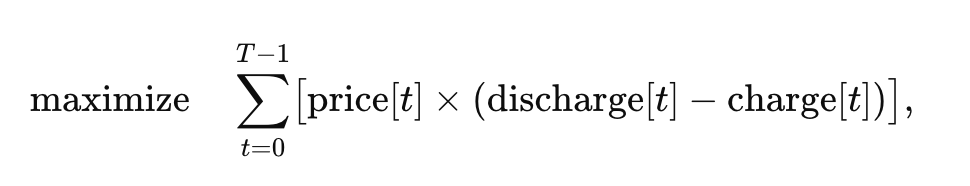


With Initial Conditions

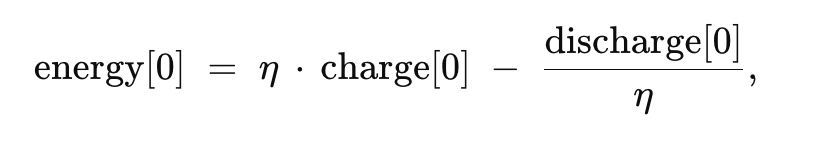



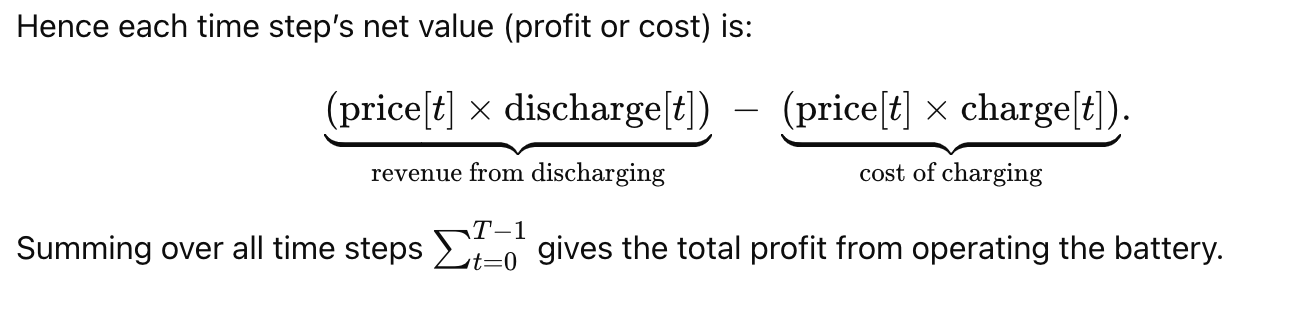

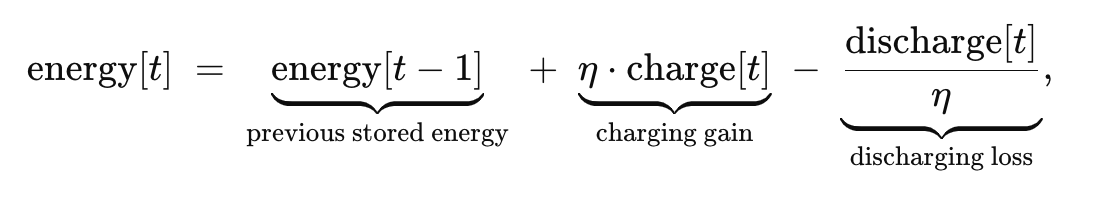

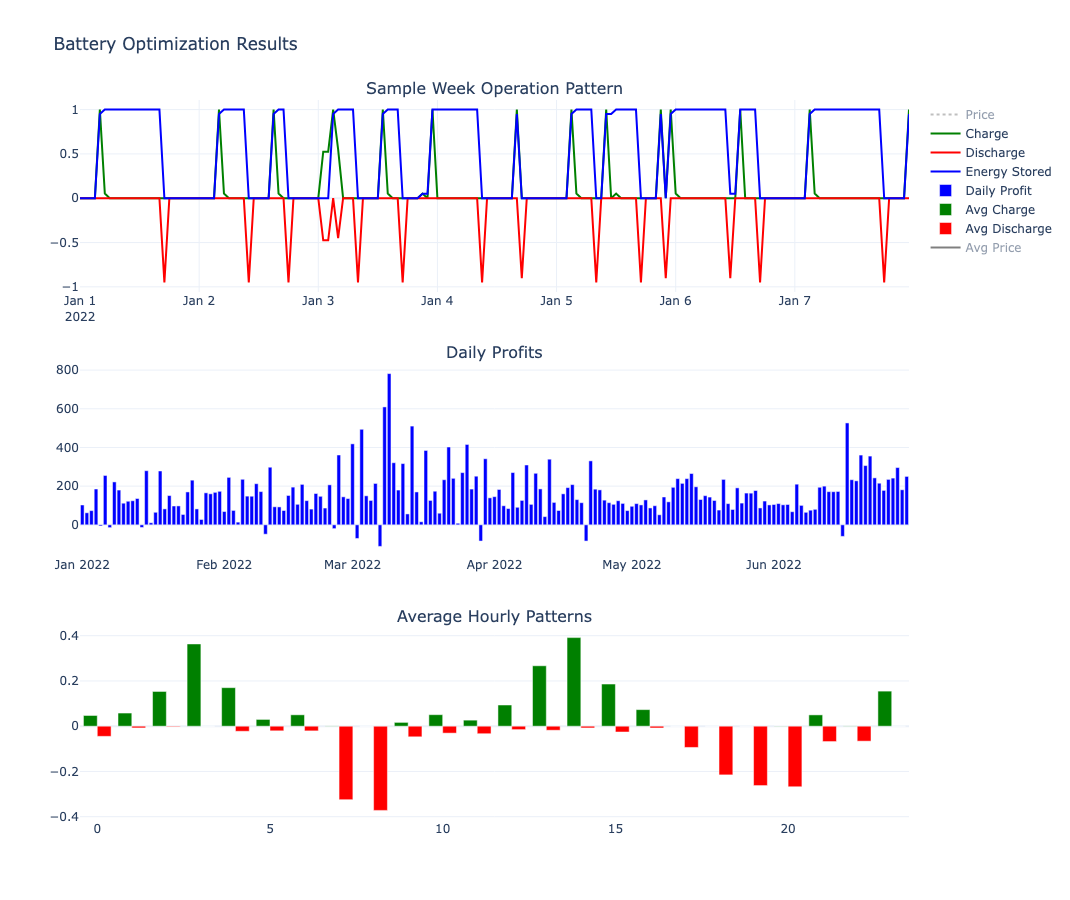

Total Profit : 29785.063219224983


In [4]:
optimizer = BatteryOptimizer(power_capacity=1.0, energy_capacity=1.0)
results = optimizer.optimize(df)
df_results, daily_stats, hourly_patterns = optimizer.analyze_results(df, results)
fig = optimizer.plot_results(df_results, daily_stats, hourly_patterns)
fig.show()
print("Total Profit :", df_results.profit.sum())

***
# Question 1.2

Suppose we now have a 1 MW, 2 MWh battery. This means the battery can charge for 2 hours with full
power when completely empty and discharge for 2 hours with full power when completely full. It can also
charge and discharge to half full by charging/discharging with full power for 1 hour. How does your answer
to question 1.1 change?


**Enhanced Flexibility:**
* The battery can now store energy from multiple low-price periods.
* Can wait longer between buying and selling operations.
* Can capture price differences across wider time windows.
* More capacity to exploit price variations across longer periods.

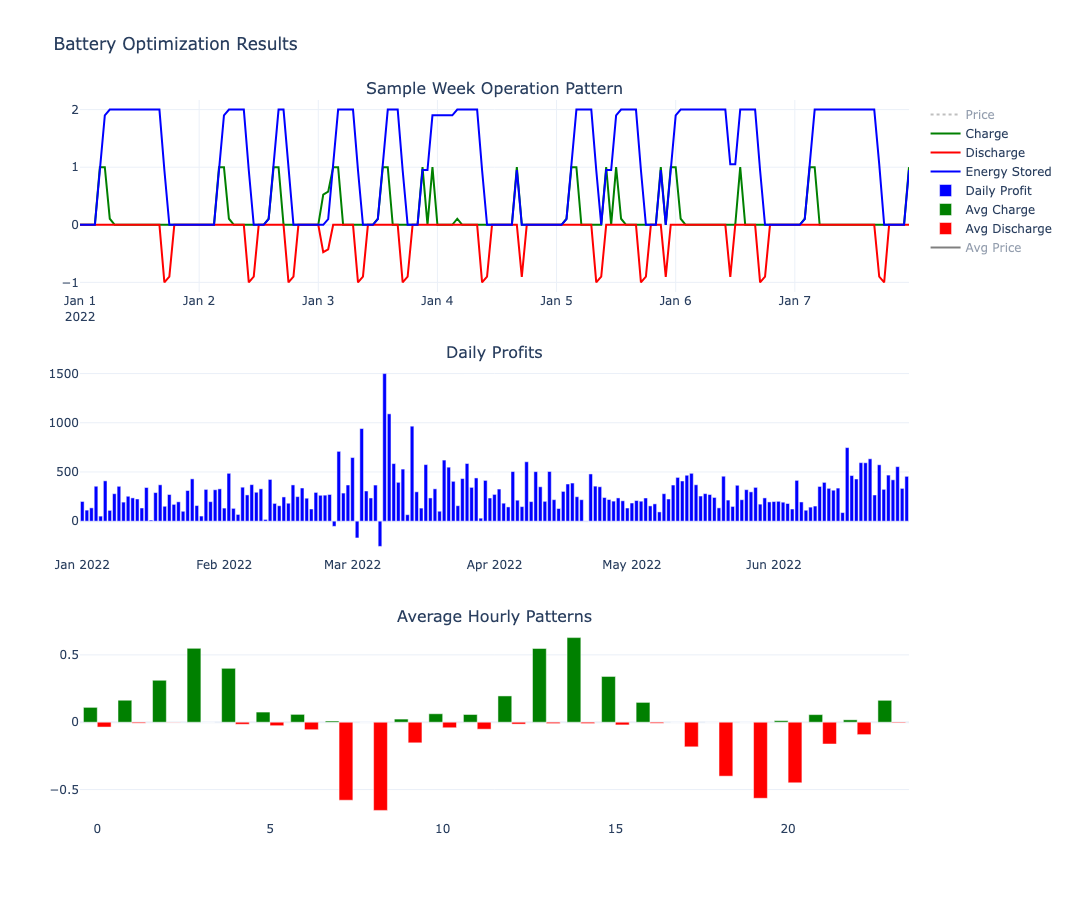

Total Profit : 54982.820487363606


In [5]:
optimizer = BatteryOptimizer(power_capacity=1.0, energy_capacity=2.0)
results = optimizer.optimize(df)
df_results, daily_stats, hourly_patterns = optimizer.analyze_results(df, results)
fig = optimizer.plot_results(df_results, daily_stats, hourly_patterns)
fig.show()
print("Total Profit :", df_results.profit.sum())

### Conclusion:
With a 1 MW, 1 MWh battery, the storage capacity allowed only one full charge and discharge cycle per day under the maximum power rating—essentially you could store or release 1 MWh of energy. Now, increasing the energy capacity to 2 MWh allows the battery to store twice as much energy. This expanded storage capability opens up new strategic possibilities and potentially increases total daily profit.


* You can store more energy and thus capitalize more thoroughly on price spreads.
* Multiple profitable cycles in a day become more feasible.
* Greater capacity means more strategic flexibility, potentially higher profits, and more nuanced operation schedules.

Key Operational Changes:
1. *Multiple Cycles Possible*
- Can perform two full charge/discharge cycles per day
- Or one extended cycle using full 2 MWh capacity
2. *Enhanced Flexibility*
- Store energy from multiple low-price periods
- Discharge during multiple high-price periods
- Hold energy longer for better price opportunities
4. *Profit Potential*
- Double the energy capacity = double potential profit
- Can capture larger price spreads
- More opportunities for arbitrage

  
The optimization model remains the same but has more flexibility in choosing optimal charge/discharge patterns across the larger capacity.

***
# Question 2 - Optimization Utilizing Forecasting
Suppose you have to decide at the beginning of each day the times at which you are going to charge and
discharge, without any knowledge of the future, i.e., any price information of that day or future days. You do
have information about past prices, however, which you may use to predict buy and sell periods. Can you
design a strategy for charging and discharging under these circumstances? For this question, go back to the
battery assumptions of 1.1, i.e. a 1MW, 1MWh battery.
Please explain your approach and in particular how you would train your trading strategy based on available
information at any point in time. Illustrate your findings, and the difference to your results in question 1.1.

*** 

### Core Idea: Predict-Then-Optimize

In the previous scenario, we had full knowledge of the day’s hourly prices, enabling an optimal "buy low, sell high" strategy. Now, you only know know past days’ price data. 


#### Phase 1

Forecasting the Day-Ahead prices before the trading day begins:

Use historical price data (for example, the previous months of hourly prices) to predict the hourly prices for the next day.
Possible modeling techniques:

* Time series models: ARIMA, SARIMA, or exponential smoothing models can capture seasonality and trends.
* Machine learning approaches: Regression models (linear regression, random forest, gradient boosting) using past prices, weather data, and known market fundamentals.
* Neural networks (e.g., LSTM, Transformer-based models) that capture complex temporal patterns.

#### Phase 2
Once we have a predicted price profile for the next day:

Treat these forecasts like “known prices” and solve the same optimization problem as in the perfect foresight scenario (from Question 1.1).
The optimization problem (linear) remains the same:
Decide the hours to charge up to 1 MWh (where predicted prices are lowest).
Decide the hours to discharge (where predicted prices are highest).





In [6]:
def prepare_data(df):
    # Convert to datetime and create features
    df['start_datetime'] = pd.to_datetime(df['start_datetime'])    
    # Rename columns for NeuralProphet
    df_prophet = df.rename(columns={
        'start_datetime': 'ds',
        'price': 'y'
    })
    # Drop unnecessary columns
    if 'end_datetime' in df_prophet.columns:
        df_prophet.drop(columns=['end_datetime'], inplace=True, errors='ignore')
    return df_prophet

def PricePredictor():
    # Model parameters
    quantiles = [0.015, 0.985]
    
    params = {
        "n_lags": 3 * 24,          
        "n_forecasts": 24,
        "n_changepoints": 30,
        "yearly_seasonality": True,
        "weekly_seasonality": True,
        "daily_seasonality": True,
        "batch_size": 64,
        "epochs": 50,
        "learning_rate": 0.01,
        "quantiles": quantiles
    }
    
    model = NeuralProphet(**params)
    return model

df_prophet = prepare_data(df)
prophet_model = PricePredictor()

df_train, df_test = prophet_model.split_df(df_prophet, valid_p=0.1)

# Train model
metrics = prophet_model.fit(df_train, freq="H", validation_df=df_test)

Epoch 1:   2%|██▏                                                                                                             | 1/50 [00:00<00:00, 650.18it/s]
Validation: 0it [00:00, ?it/s]
Epoch 1:   2%|▌                        | 1/50 [00:00<00:38,  1.27it/s, loss=0.726, v_num=15, MAE_val=198.0, RMSE_val=255.0, Loss_val=0.732, RegLoss_val=0.000]
Epoch 2:   4%| | 2/50 [00:00<00:00, 1131.91it/s, loss=0.726, v_num=15, MAE_val=198.0, RMSE_val=255.0, Loss_val=0.732, RegLoss_val=0.000, MAE=264.0, RMSE=338.0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                                                          | 0/1 [00:00<?, ?it/s]
Epoch 2:   4%| | 2/50 [00:00<00:20,  2.38it/s, loss=0.236, v_num=15, MAE_val=116.0, RMSE_val=153.0, Loss_val=0.275, RegLoss_val=0.000, MAE=264.0, RMSE=338.0, 
Epoch 3:   6%| | 3/50 [00:00<00:00, 1813.62it/s, loss=0.236, v_num=15, MAE_val=116.0, RMSE_val=153.0, Loss_val=0.275, RegLoss_val=0.000, MAE=13

Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.75it/s]

ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


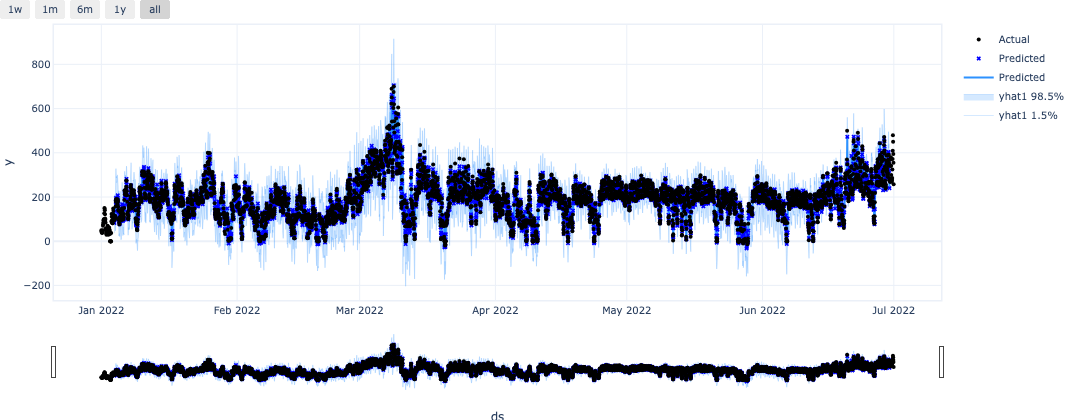

In [8]:
prediction = prophet_model.predict(df_prophet)
prophet_model.highlight_nth_step_ahead_of_each_forecast(1).plot(prediction)

In [11]:
if 'yhat1' in prediction.columns:
    forecast_col = 'yhat1'
else:
    forecast_col = [c for c in prediction.columns if 'yhat' in c][0]
    
actual = prediction[['ds', 'y']].dropna()
predicted = prediction[['ds', forecast_col]].dropna().rename(columns={forecast_col: 'yhat'})

# Merge actual and predicted to have a consistent frame
merged = pd.merge(actual, predicted, on='ds', how='inner')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
# Separate train and test sets based on ds
test_start = df_test['ds'].min()
train_data = merged[merged['ds'] < test_start]
test_data = merged[merged['ds'] >= test_start]

# Compute error metrics on the test set
mae = mean_absolute_error(test_data['y'], test_data['yhat'])
mse = mean_squared_error(test_data['y'], test_data['yhat'])
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")

Train shape: (3899, 2)
Test shape: (517, 2)
Model Performance on Test Set:
MAE: 16.478
MSE: 512.886
RMSE: 22.647


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.64it/s]


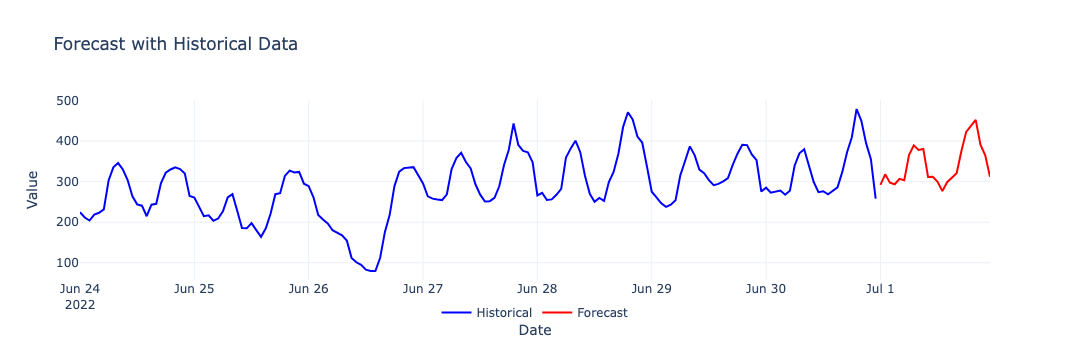

In [12]:
future_df = prophet_model.make_future_dataframe(df=df_prophet, periods=168, n_historic_predictions=True)
forecast = prophet_model.predict(df=future_df)

last_historical_date = df_prophet['ds'].max()
future_forecast = forecast[forecast['ds'] > last_historical_date]
historical_data = df_prophet[df_prophet['ds'] > (last_historical_date - pd.Timedelta(hours=168))]


# Create the figure
fig = go.Figure()

# Add historical prices
fig.add_trace(
    go.Scatter(
        x=historical_data['ds'],
        y=historical_data['y'],
        mode='lines',
        name='Historical',
        line=dict(color='blue'),
    )
)

# Add forecast
fig.add_trace(
    go.Scatter(
        x=future_forecast['ds'],
        y=future_forecast['yhat24'],
        mode='lines',
        name='Forecast',
        line=dict(color='red'),
    )
)

# Update layout
fig.update_layout(
    title="Forecast with Historical Data",
    xaxis_title="Date",
    yaxis_title="Value",
    legend=dict(orientation="h", x=0.5, xanchor="center"),
    template="plotly_white",
)

# Show the figure
fig.show()


For this assigment, I chose NeuralProphet because it's particularly good at handling electricity price patterns - you know, those daily and weekly cycles when prices go up and down. It's like having a tool that's already set up to understand energy market behaviors out of the box. Plus, it's pretty straightforward to use and interpret the results, which was important given our project timeline.

If I had more time and data to play with, I'd probably try building a fancier system that combines different types of models - maybe throw in some LSTM networks and add some weather forecasts and power demand data into the mix. These external factors tend to have a big impact on electricity prices, and capturing them could make our predictions even more accurate. But for now, NeuralProphet gives us a solid foundation to work with.

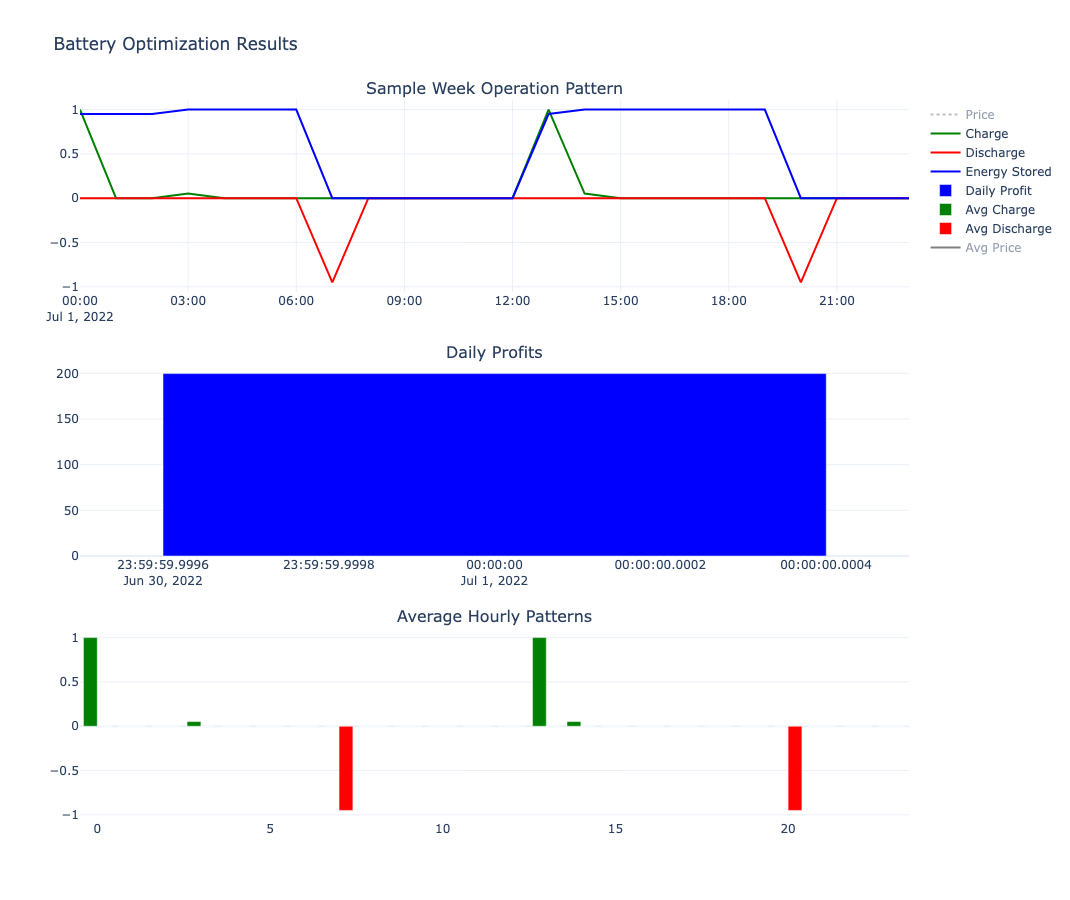

Total Profit : 199.73618867669052


In [13]:
df_forecast_strategy = future_forecast[['ds', 'yhat24']].copy()
df_forecast_strategy.rename(columns={'ds':'start_datetime','yhat24':'price'}, inplace=True)

optimizer = BatteryOptimizer(power_capacity=1.0, energy_capacity=1.0)
results = optimizer.optimize(df_forecast_strategy)
df_results, daily_stats, hourly_patterns = optimizer.analyze_results(df_forecast_strategy, results)
fig = optimizer.plot_results(df_results, daily_stats, hourly_patterns)
fig.show()
print("Total Profit :", df_results.profit.sum())

***
# Question 3 - Data Exploration
Use the 60 min and 15 min data for this part. Both data sets contain prices for electricity from the first 6
months of 2022. The 15 min data contains prices for 15 minutes contracts, i.e. delivery of electricity at a
constant power over 15 minutes. The 60 min data is for 60 minutes contracts.
Please summarize and compare both data sets statistically. 

* Are there any patterns in the data that bothshare and are there others that differ between them? 
* Can you make a recommendation for which type of contract would be more beneficial to trade in for Entrix?

In [14]:
df_15min = pd.read_csv('Day-ahead_Prices_15min.csv')
df_15min[['start_datetime', 'end_datetime']] = df_15min['MTU (CET/CEST)'].str.split(' - ', expand=True)
df_15min['start_datetime'] = pd.to_datetime(df_15min['start_datetime'], format='%d.%m.%Y %H:%M')
df_15min['end_datetime'] = pd.to_datetime(df_15min['end_datetime'], format='%d.%m.%Y %H:%M')
df_15min.drop(columns=['MTU (CET/CEST)','Currency','BZN|DE-LU'], inplace=True)
df_15min.rename(columns={'Day-ahead Price [EUR/MWh]':'price'}, inplace=True)
df_15min['price'] = pd.to_numeric(df_15min['price'],errors='coerce')
df_15min.ffill(inplace=True)

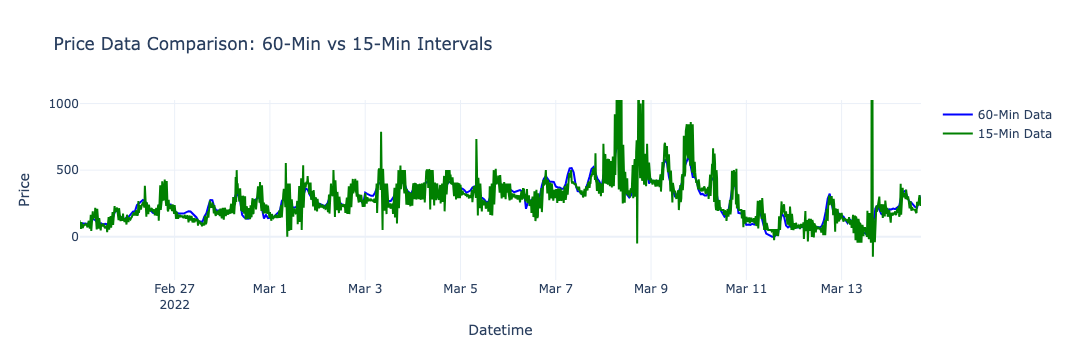

In [15]:
fig = go.Figure()

# Add 60-Min data trace
fig.add_trace(go.Scatter(
    x=df.start_datetime,
    y=df.price,
    mode='lines',
    name='60-Min Data',
    line=dict(color='blue')
))

# Add 15-Min data trace
fig.add_trace(go.Scatter(
    x=df_15min.start_datetime,
    y=df_15min.price,
    mode='lines',
    name='15-Min Data',
    line=dict(color='green')
))

# Update layout for better visualization
fig.update_layout(
    title="Price Data Comparison: 60-Min vs 15-Min Intervals",
    xaxis_title="Datetime",
    yaxis_title="Price",
    #yaxis_range=[min(df.price.min(), df_15min.price.min()), max(df.price.max(), df_15min.price.max())],
    #xaxis=dict(range=['2020-01-15', '2020-01-19']),  # Adjusted for datetime filtering
    #legend=dict(orientation="h", x=0.8, xanchor="center"),
    template="plotly_white"
)

fig.show()


Both datasets share broad daily cycles linked to predictable demand patterns, such as higher prices during peak consumption hours (mornings, early evenings) and lower prices at night. The 60-minute data show a smoothed version of these cycles; the 15-minute data offers more fine-grained insight into exactly when transitions occur. The key difference will be within-hour patterns. 

Over weeks and months, both datasets should capture similar longer-term trends—e.g., higher prices during certain months due to fuel costs, weather, or system demand. The difference is that 15-minute data will provide more granular evidence of how these trends manifest intraday.

In [16]:
df_15min.describe()[['price']]

price
count  17376.000000
mean     186.970947
min     -149.990000
25%      127.857500
50%      184.620000
75%      237.472500
max     2999.990000
std      102.877103

In [17]:
df.describe()[['price']]

price
count  4344.000000
mean    185.810483
min     -19.040000
25%     122.155000
50%     189.005000
75%     232.927500
max     700.000000
std      90.648040

Both 60-minute and 15-minute datasets have similar average prices over the same 6-month period, as they represent the same underlying market, just at different contract intervals.

However, because the 15-minute data captures more granularity, short-lived spikes or dips that get “averaged out” in hourly data could affect the average slightly. One might see the 15-minute data having a slightly higher standard deviation, possibly influencing the mean if price spikes are frequent.



The 15-minute data shows a higher short-term volatility. Frequent, rapid fluctuations appear more vividly in 15-minute intervals than in hourly intervals, where prices are more smoothed out.
For instance, if there’s a price spike lasting only 15 minutes within an hour, the hourly price might not fully reflect that spike, while the 15-minute data would capture it precisely.

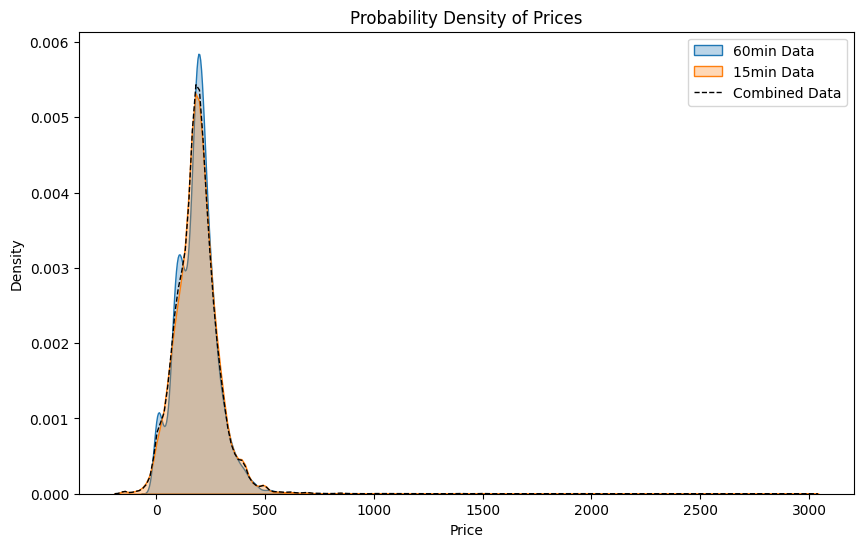

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

combined_prices = pd.concat([df['price'], df_15min['price']], ignore_index=True)
# Plot KDE (Probability Density Function)
plt.figure(figsize=(10, 6))
sns.kdeplot(df['price'], label='60min Data', fill=True, alpha=0.3)
sns.kdeplot(df_15min['price'], label='15min Data', fill=True, alpha=0.3)
sns.kdeplot(combined_prices, label='Combined Data', color='black', linewidth=1, linestyle='--')

plt.title("Probability Density of Prices")
plt.xlabel("Price")
plt.ylabel("Density")
plt.legend()
plt.show()


The 15-minute data is slightly more “spread out” with fatter tails, indicating occasional extreme values that the hourly data does not isolate as clearly.

I wanted to dig deeper into the exact hours when demand spikes and dips. Since we typically charge during low-price periods and discharge during peak prices, I came up with a simple methodology to figure this out. It's nothing groundbreaking—this concept is pretty well-known—but applying it to our data gives us a clearer picture of how demand and prices behave. This helps us make smarter decisions and better align with market trends.

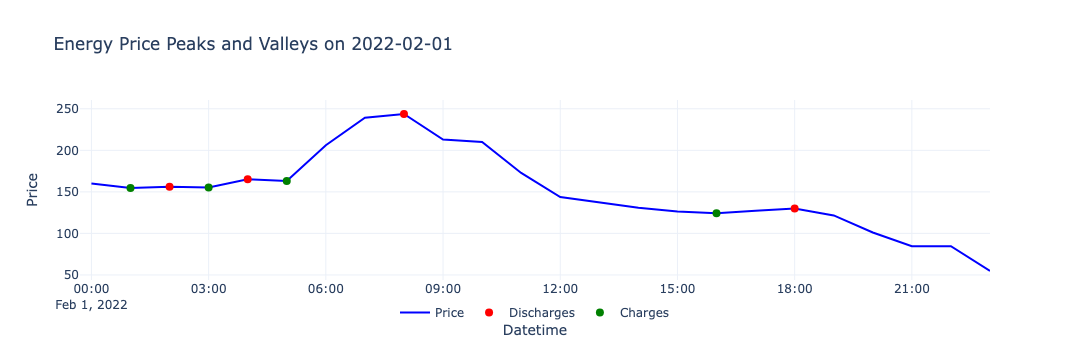

In [19]:
# Identify peaks and valleys
prices = df['price'].values
peaks, _ = find_peaks(prices)  # Local maxima
valleys, _ = find_peaks(-prices)  # Local minima

# Add peaks and valleys to DataFrame
df['peak'] = 0
df['valley'] = 0
df.loc[peaks, 'peak'] = 1
df.loc[valleys, 'valley'] = 1

# Analyze patterns
df['hour'] = df['start_datetime'].dt.hour
peak_hours = df.loc[df['peak'] == 1, 'hour'].value_counts().sort_index()
valley_hours = df.loc[df['valley'] == 1, 'hour'].value_counts().sort_index()


selected_date = '2022-02-01'
daily_df = df[df['start_datetime'].dt.date == pd.to_datetime(selected_date).date()]

# Create Plotly figure for one day
fig = go.Figure()

# Add price line
fig.add_trace(go.Scatter(
    x=daily_df['start_datetime'],
    y=daily_df['price'],
    mode='lines',
    name='Price',
    line=dict(color='blue')
))

# Add peaks
fig.add_trace(go.Scatter(
    x=daily_df.loc[daily_df['peak'] == 1, 'start_datetime'],
    y=daily_df.loc[daily_df['peak'] == 1, 'price'],
    mode='markers',
    name='Discharges',
    marker=dict(color='red', size=8, symbol='circle')
))

# Add valleys
fig.add_trace(go.Scatter(
    x=daily_df.loc[daily_df['valley'] == 1, 'start_datetime'],
    y=daily_df.loc[daily_df['valley'] == 1, 'price'],
    mode='markers',
    name='Charges',
    marker=dict(color='green', size=8, symbol='circle')
))

# Update layout
fig.update_layout(
    title=f'Energy Price Peaks and Valleys on {selected_date}',
    xaxis_title='Datetime',
    yaxis_title='Price',
    legend=dict(orientation='h', x=0.5, xanchor='center'),
    template='plotly_white'
)

# Show the figure
fig.show()

In [20]:
# Total counts for charging and discharging
total_charging = df['valley'].sum()
total_discharging = df['peak'].sum()

# Percentage statistics for charging
charging_stats = (
    df.loc[df['valley'] == 1]
    .groupby('hour')['valley']
    .count()
    .sort_index()
    .reset_index(name='count')
)
charging_stats['percentage'] = (charging_stats['count'] / total_charging) * 100

# Percentage statistics for discharging
discharging_stats = (
    df.loc[df['peak'] == 1]
    .groupby('hour')['peak']
    .count()
    .sort_index()
    .reset_index(name='count')
)
discharging_stats['percentage'] = (discharging_stats['count'] / total_discharging) * 100

# Merge results for comparison
hourly_stats = pd.merge(
    charging_stats.rename(columns={'count': 'charging_count', 'percentage': 'charging_percentage'}),
    discharging_stats.rename(columns={'count': 'discharging_count', 'percentage': 'discharging_percentage'}),
    on='hour',
    how='outer'
).fillna(0)

# Display hourly statistics
print("\nHourly Charging and Discharging Statistics:")
hourly_stats



Hourly Charging and Discharging Statistics:


hour  charging_count  charging_percentage  discharging_count  \
0      0            15.0             2.546689               58.0   
1      1            27.0             4.584041               13.0   
2      2            35.0             5.942275               21.0   
3      3            84.0            14.261460               13.0   
4      4            44.0             7.470289               11.0   
5      5            11.0             1.867572               15.0   
6      6            19.0             3.225806                8.0   
7      7             1.0             0.169779               69.0   
8      8             4.0             0.679117               76.0   
9      9             5.0             0.848896               16.0   
10    10            27.0             4.584041                6.0   
11    11             9.0             1.528014               24.0   
12    12            25.0             4.244482               12.0   
13    13            48.0             8.149406                9.0   
14    14            73.0            12.393888                4.0   
15    15            31.0             5.263158                9.0   
16    16            19.0             3.225806                0.0   
17    17             0.0             0.000000               19.0   
18    18             1.0             0.169779               42.0   
19    19             2.0             0.339559               51.0   
20    20             5.0             0.848896               54.0   
21    21            37.0             6.281834               16.0   
22    22             2.0             0.339559               42.0   
23    23            65.0            11.035654                1.0   

    discharging_percentage  
0                 9.847199  
1                 2.207131  
2                 3.565365  
3                 2.207131  
4                 1.867572  
5                 2.546689  
6                 1.358234  
7                11.714771  
8                12.903226  
9                 2.716469  
10                1.018676  
11                4.074703  
12                2.037351  
13                1.528014  
14                0.679117  
15                1.528014  
16                0.000000  
17                3.225806  
18                7.130730  
19                8.658744  
20                9.168081  
21                2.716469  
22                7.130730  
23                0.169779

In [21]:
hourly_stats[['hour', 'charging_percentage']].sort_values(by=['charging_percentage'],  ascending=False).head()

hour  charging_percentage
3      3            14.261460
14    14            12.393888
23    23            11.035654
13    13             8.149406
4      4             7.470289

In [22]:
hourly_stats[['hour', 'discharging_percentage']].sort_values(by=['discharging_percentage'],  ascending=False).head()

hour  discharging_percentage
8      8               12.903226
7      7               11.714771
0      0                9.847199
20    20                9.168081
19    19                8.658744

Key Pattern Recognition:
* The battery charges during price valleys (around hours 3-4 and 16-17)
* Discharges during price peaks (around hours 7-8 and 20-21)
* Energy storage follows a clear cycle of filling up before price peaks

 ***
## Recommendations for Entrix




| **Category**             | **Pros**                                                                                     | **Cons**                                                                                   |
|---------------------------|---------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| **60-Min Contracts**      | - Simpler analysis with fewer data points. <br> - Lower operational complexity. <br> - Less volatility, easier forecasting. | - Misses short-term price spikes/dips. <br> - Lower profit margins for flexible batteries. |
| **15-Min Contracts**      | - Granular price data offers more arbitrage opportunities. <br> - Optimized timing can boost profits. | - Higher complexity in forecasting and execution. <br> - Increased risk due to volatility. |

**Which Contract Type is More Beneficial?**
It depends on Entrix’s capabilities and objectives.

* If Entrix aims for simplicity and lower risk, hourly contracts might be more stable and easier to manage. The strategic complexity is lower, forecasting is somewhat easier, and while profits might be less, the operation will be more predictable.

* If Entrix has a sophisticated forecasting algorithm and is comfortable with risk, the 15-minute contracts can offer more opportunities to exploit short-lived price anomalies. A fast-response storage asset (like a battery) could earn higher margins by capitalizing on these finer-grained fluctuations.


In general, given a well-managed forecasting and optimization framework, the higher granularity could provide better profit opportunities. However, it would require more investment in analytical tools and possibly a more active trading strategy. I think Entrix is equipped with advanced analytics, algorithmic trading strategies, and a tolerance for complexity, therefore, the  **15-minute market** might be more beneficial in the long run.
